In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from PIL import Image as im

##### 0, Define the hyper parameters

In [25]:
"TODO: change hyper parameters"
n_epochs = 15 #Initially 3. 
batch_size_train = 64 
batch_size_test = 1000
learning_rate = 0.1 #Changed manually with different optimization functions
momentum = 0.5

##### 1, Loading training and testing data

#### Organizing images

First, we need to create a directory structure to hold our images.
The directory <em>training2</em> will hold 10 directories, corresponding to class labels.

This is so we can load the images using torchvision.datasets.ImageFolder, which expects the format described above.

In [26]:
import os

#Make training2 directory
if not os.path.exists('training2'):
    os.mkdir("training2")
#Create the subdirectories corresponding to class labels
for i in range(10):
    if not os.path.exists("training2/{}".format(i+1)):
        os.mkdir("training2/{}".format(i + 1))

In [27]:
import shutil

#Iterate through labels.txt, copying images from training into training2 based on their class label
file = open("labels.txt","r")
for line in file.readlines():
    text = line.strip().split("\t")
    shutil.copy("training/" + text[0], "training2/{0}/".format(text[1]))
file.close()

In [40]:
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])
dataset = datasets.ImageFolder('training2',transform=transform)

In [41]:
#Splitting the dataset into a testing and training set
trainset,testset = random_split(dataset,[600,260])

Passing the dataset to a dataloader

In [42]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=True)

##### 1.3 First, check the documentation of dataloader

In [43]:
# trainloader = torch.utils.data.DataLoader(trainset0, batch_size=batch_size_train, shuffle=True)
# testloader = torch.utils.data.DataLoader(testset0, batch_size=batch_size_test, shuffle=True)

1.4 Data visualization

IndexError: index 20 is out of bounds for dimension 0 with size 20

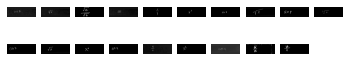

In [50]:
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

##### 2 Define the model

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, -1)


In [46]:
"Read the documentation of torchvision.models to try more cnn models"

'Read the documentation of torchvision.models to try more cnn models'

##### 3 Write the training function and the testing function

In [47]:
def test(model, test_loader, device):
    # evaluation, freeze 
    model.eval()
    total_num = 0
    total_correct = 0
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            
            data = data.to(device)
            target = target.to(device)
            
            predict_one_hot = model(data)
            
            _, predict_label = torch.max(predict_one_hot, 1)
            
            total_correct += (predict_label == target).sum().item()
            total_num += target.size(0)
        
    return (total_correct / total_num)
            

In [48]:
def train(model, train_loader, test_loader, num_epoch, learning_rate, momentum, device):
    train_losses = []
    
    # 1, define optimizer
    
    "TODO: try different optimizer"
    
    
    #optimizer = optim.SGD(network.parameters(), lr=learning_rate,
    #                  momentum=momentum)
    
    #The Adam algorithm should be more expensive to train, but may result in a higher accuracy
    optimizer = optim.Adam(network.parameters()) #Using default learning rate of 1e-3
    #optimizer = optim.AdamW(network.parameters())
    
    for epoch in tqdm(range(num_epoch)):
        # train the model
        model.train()
        
        for i, (data, target) in enumerate(train_loader):
            
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            
            # 2, forward
            output = network(data)
            
            
            # 3, calculate the loss
            
            
            
            
            "TODO: try use cross entropy loss instead "
            
            
            #loss = F.nll_loss(output, target)
            
            loss = F.cross_entropy(output, target)
            
            # 4, backward
            loss.backward()
            
            
            optimizer.step()
            
        # evaluate the accuracy on test data for each epoch
        accuracy = test(model, test_loader, device)
        print('accuracy', accuracy)
        
    # 5, save model
    
    "TODO: change the number of epochs save the model with the best prediction accuracy"
    

In [49]:
device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# use cpu if you do not have gpu installed in your computer
network = Net().to(device0)
train(model=network, train_loader=trainloader, test_loader=testloader, num_epoch=n_epochs, learning_rate=learning_rate, momentum=momentum, device=device0)

  0%|                                                    | 0/15 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 320]' is invalid for input of size 1642800

#### 4 Calculate the accuracy

0.98625 accuracy using the provided optimizer (SGD), loss function (SGD), and epochs (3).

0.9895 accuracy using Adam optimization algorithm, cross entropy loss function, and 3 epcohs.

0.99005 accuracy using Adam optimization algorithm, cross entropy loss function, and 5 epochs.

0.98985 accuracy using AdamW optimization algorithm, cross entropy loss function, and 5 epochs.

0.991325 accuracy using Adam optimization algorithm, cross entropy, and 15 epochs. 

Increasing the number of epochs increased the accuracy overall.

The Adam or AdamW optimization algorithms seem to be the most accurate than SGD.

I am running this on a virtual machine with 3gb of RAM, 1 cpu core, and no gpu, so training this takes a very long time.

### Saving the model trained with Adam, cross entropy, 15 epochs

In [ ]:
torch.save(network, './MNIST_model.pt') 

# 5 - Using a model without convolution

Of course, a CNN is better suited for image recognition, but I want to compare it to a sequential model without convolution to see how it performs.

Source: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

### Building the network

In [ ]:
input_size = 784 #28*28 pixels
hidden_sizes = [128, 64] #128 neurons in first hidden layer, 64 in second
output_size = 10 #10 digits, 10 outputs

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(), 
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

In [ ]:
criterion = nn.NLLLoss() #nll loss function, same as initial above
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9) #SGD optimizer, same as the initial optimizer above
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

### Testing this model

In [ ]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

0.984125 accuracy with 5 epochs, SGD optimization, and nll loss function.

Using the same optimization algorithm and loss function above in the CNN, we achieved 0.98625 accuracy in just 3 epochs.

CNN therefore appears better suited to image recognition, although using this model is not far off. 

# In Conclusion:

For the CNN, the Adam algorithm works better than the SGD.

Cross entropy worked better than nll as a loss function.

More epochs are better. I tested 3, 5, and 15. 

After 5 epochs, the accuracy went down slightly before rising again. 

Using convolution, we can achieve higher image classification accuracy.


Overall, I felt that I was limited by the performance of my computer. As mentioned above, I am running this on a virtual machine with 3gb RAM, 1 CPU core, and no CUDA/GPU. I imagine that if I had a better computer, I could more easily test different hyper-parameters and increase the number of epochs. 